In [1]:
import numpy as np
import warnings  
warnings.filterwarnings('ignore', category=FutureWarning)  

from vade_new import VaDE
from utility import create_project_folders, set_random_seed,set_device
from config import config
import torch
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

set_random_seed(123)

2026-01-14 09:32:15.415793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data and Model

In [2]:
# datasets
X_train = np.flip(np.load('/mnt/sda/gene/zhangym/VADER/Data/NC_9/X_reference.npy'), axis=1)
y_train = np.load('/mnt/sda/gene/zhangym/VADER/Data/NC_9/y_reference.npy').astype(int)
X_finetune = np.flip(np.load('/mnt/sda/gene/zhangym/VADER/Data/NC_9/X_finetune.npy'), axis=1)
y_finetune = np.load('/mnt/sda/gene/zhangym/VADER/Data/NC_9/y_finetune.npy').astype(int)
X_test = np.flip(np.load('/mnt/sda/gene/zhangym/VADER/Data/NC_9/X_test.npy'), axis=1)
y_test = np.load('/mnt/sda/gene/zhangym/VADER/Data/NC_9/y_test.npy').astype(int)
wave = np.flip(np.load(r'/mnt/sda/gene/zhangym/VADER/Data/NC_9/wavenumbers.npy'),axis=0)

In [3]:
S = np.flip(np.load(r"/mnt/sda/gene/zhangym/VADER/Data/NC_All/MCR_NCAll_Raw_30_component.npy"),axis=1)
device = "cuda:1"
project_tag = '/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model'
epochs = 300
batch_size = 128
memo = "NC_All"

model_params = config.get_model_params()
device = set_device(device)
tensor_data = torch.tensor(X_train.copy(), dtype=torch.float32)
tensor_gpu_data = tensor_data.to(device)
input_dim = tensor_data.shape[1]
project_dir = create_project_folders(project_tag)
weight_scheduler_config = config.get_weight_scheduler_config()
n_component = S.shape[0]
paths = config.get_project_paths( project_dir, memo=memo )
l_c_dim = config.encoder_type(model_params['encoder_type'], paths['train_path'])
model = VaDE(
    input_dim=input_dim,
    intermediate_dim=model_params['intermediate_dim'],
    latent_dim=n_component,
    tensor_gpu_data=tensor_gpu_data,
    n_components=n_component,
    S=torch.tensor(S.copy()).float().to(device),
    wavenumber = wave,
    prior_y=y_train,
    device=device,
    l_c_dim=l_c_dim,
    encoder_type=model_params['encoder_type'],
    pretrain_epochs=50,
    num_classes=50,
    clustering_method=model_params['clustering_method'],
    resolution=model_params['resolution']
).to(device)

成功复制配置文件到: /mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model/NC_All


In [4]:
model.load_state_dict(torch.load('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/0107_cVADER_Instrument_test/Change_gmm/Change_gmm_model_dict_cVADER_4000.pk'))

<All keys matched successfully>

# UMAP Plots between datasets

In [5]:
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_UMAP(
    X: np.ndarray,
    labels: np.ndarray,
    save_path: str,
    x_lim = None,
    y_lim = None,
    width = 8,
    height = 6):

    uniq_labels = np.unique(labels)
    n_classes = len(uniq_labels)
    label_to_idx = {lbl: i for i, lbl in enumerate(uniq_labels)}
    labels_idx = np.array([label_to_idx[lbl] for lbl in labels])
    
    if n_classes <= 2:
        palette = ['#F28E2B', '#9E9E9E']  # 橙 + 灰
    if n_classes == 3:
        palette = ['#F28E2B', '#9E9E9E', '#1F77B4']  # 橙 + 灰 + 蓝
    if n_classes >= 3:
        palette = sns.color_palette('husl', n_colors=n_classes)
    cmap = ListedColormap(palette)
    norm = BoundaryNorm(np.arange(n_classes+1)-0.5, n_classes)

    fig, ax = plt.subplots(figsize=(width, height))
    sc = ax.scatter(X[:, 0], X[:, 1], c=labels_idx, cmap=cmap, norm=norm, s=10, linewidths=0, alpha=0.3)
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)

    handles = [
        Line2D([0], [0], marker="o", color="none", markerfacecolor=cmap(i), markersize=6)
        for i in range(n_classes)
    ]

    for h, lbl in zip(handles, uniq_labels):
        h.set_label(str(lbl))
    ax.legend(handles=handles, title="Label", loc='best', fontsize='small', frameon=False)

    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=500)

In [16]:
# Show datasets 
import umap 
from sklearn.decomposition import PCA
import numpy as np
import os

X = np.vstack((X_finetune, X_test))
Y = np.array(['Finetune'] * X_finetune.shape[0] + ['Test'] * X_test.shape[0] ) 
Y = np.hstack((y_finetune, y_test))

pca = PCA(n_components=20)  
X_pca = pca.fit_transform(X)

umap_reducer = umap.UMAP( n_components=2, n_neighbors=50,  min_dist=0.01, spread=1, metric='cosine', random_state=42, a = 0.9922, b = 1.112) 
z_umap = umap_reducer.fit_transform(X_pca)

plot_UMAP( z_umap, Y, os.path.join('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model', 'Umap_Finetune_Test.png') , width = 5, height = 4)

/home/gene/zhangym/.conda/envs/ID_PY390/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


KeyboardInterrupt: 

In [5]:
recon_x, z_mean, z_log_var, z_train, S = model(torch.tensor(X_test.copy(), dtype=torch.float32).to(device))
recon_x, z_mean, z_log_var, z_finetune, S = model(torch.tensor(X_finetune.copy(), dtype=torch.float32).to(device))
idx = model.activate_clusters
means = F.softplus(model.c_mean[idx]).detach().cpu().numpy()
vars_ = np.exp(model.c_log_var[idx].detach().cpu().numpy())
S = model.encoder.S.detach().cpu().numpy()
std = np.sqrt(vars_)
gamma_train = model.cal_gaussian_gamma(torch.tensor(z_train).float().to(model.device)).detach().cpu().numpy()  
gmm_labels_train = np.argmax(gamma_train, axis=1)
gamma_finetune = model.cal_gaussian_gamma(torch.tensor(z_finetune).float().to(model.device)).detach().cpu().numpy()  
gmm_labels_finetune = np.argmax(gamma_finetune, axis=1)

/tmp/ipykernel_1399057/1528870461.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_train = model.cal_gaussian_gamma(torch.tensor(z_train).float().to(model.device)).detach().cpu().numpy()
/tmp/ipykernel_1399057/1528870461.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_finetune = model.cal_gaussian_gamma(torch.tensor(z_finetune).float().to(model.device)).detach().cpu().numpy()


In [15]:
# 中心偏移/STD变化对Gamma的影响
z_mean_finetune = pd.DataFrame(z_finetune.detach().cpu().numpy())
z_mean_finetune['group'] = y_finetune
z_centers_finetune = z_mean_finetune.groupby('group').mean()
z_vars_finetune = z_mean_finetune.groupby('group').var()
new_mean = model.c_mean.detach().clone()
new_mean[np.arange(30)] = torch.tensor(z_centers_finetune.values,dtype=torch.float64).to(device)
new_vars = model.c_log_var.detach().clone()
new_vars[np.arange(30)] = torch.tensor(np.log(z_vars_finetune.values),dtype=torch.float64).to(device)

with torch.no_grad():
    model.c_mean.copy_(new_mean)
    model.c_log_var.copy_(new_vars)
gamma_finetune = model.cal_gaussian_gamma(torch.tensor(z_finetune).float().to(model.device)).detach().cpu().numpy() 
gmm_labels_finetune = np.argmax(gamma_finetune, axis=1) 
gamma_train = model.cal_gaussian_gamma(torch.tensor(z_train).float().to(model.device)).detach().cpu().numpy()  
gmm_labels_train = np.argmax(gamma_train, axis=1)

/tmp/ipykernel_557976/2815606335.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_finetune = model.cal_gaussian_gamma(torch.tensor(z_finetune).float().to(model.device)).detach().cpu().numpy()
/tmp/ipykernel_557976/2815606335.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_train = model.cal_gaussian_gamma(torch.tensor(z_train).float().to(model.device)).detach().cpu().numpy()


In [ ]:
# 错误的那些gamma的分布
wrong_idx = gmm_labels_train != y_finetune
np.unique(wrong_idx, return_counts=True)
gamma_train[wrong_idx] 

array([[1.47749997e-04, 9.99852250e-01, 7.50150915e-28, ...,
        7.49300780e-63, 5.45778655e-35, 2.82180929e-36],
       [2.07023697e-01, 1.05320933e-21, 7.05198443e-08, ...,
        9.84881086e-79, 3.62174040e-15, 3.87682974e-18],
       [2.71122584e-13, 2.00328698e-21, 2.35572293e-01, ...,
        6.73498084e-35, 4.80952258e-09, 1.93442089e-10],
       ...,
       [9.43462719e-15, 2.30929660e-23, 4.33033905e-08, ...,
        3.61786439e-52, 1.02661924e-07, 3.77559310e-01],
       [8.49669726e-10, 2.28625835e-21, 2.03145617e-06, ...,
        4.31067421e-36, 6.49839536e-07, 3.67493915e-01],
       [1.17661922e-08, 3.76464953e-22, 4.41351273e-08, ...,
        4.88925224e-35, 1.53374693e-07, 4.66358542e-01]])

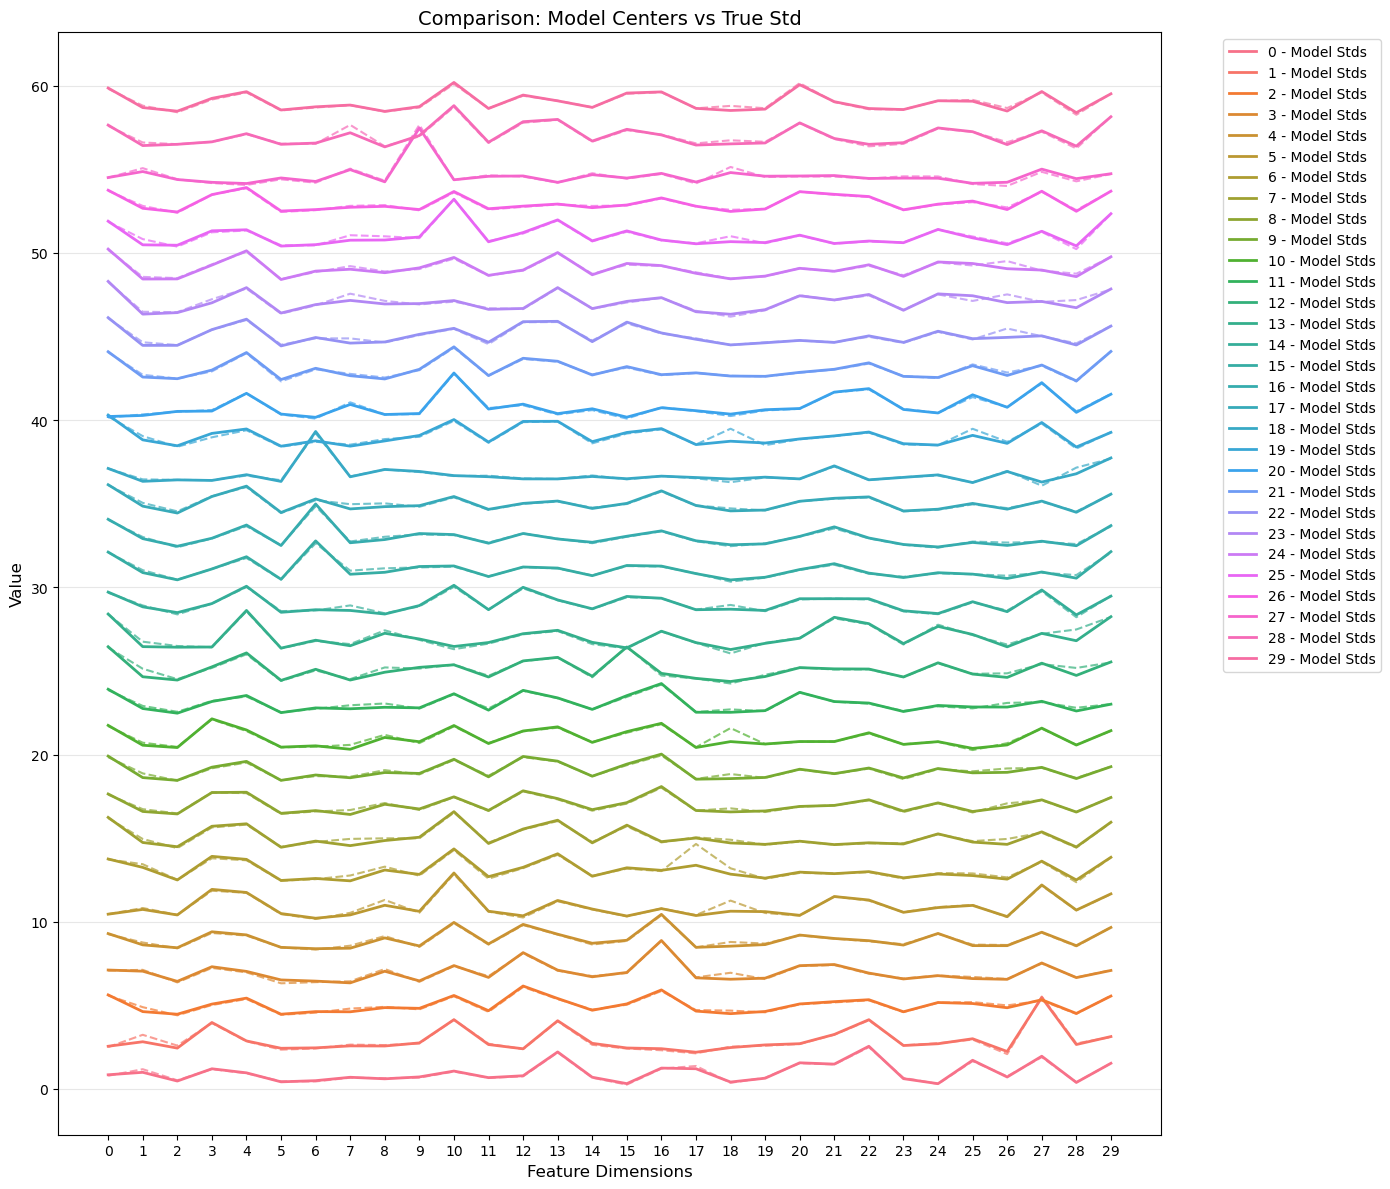

In [22]:
# Draw centers / vars of calculated and true parameter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_features = model.c_mean[idx].shape[1]
z_mean_test = pd.DataFrame(z_train.detach().cpu().numpy())
z_mean_test['group'] = y_test
z_centers_test = z_mean_test.groupby('group').std()
z_mean_finetune = pd.DataFrame(z_finetune.detach().cpu().numpy())
z_mean_finetune['group'] = y_finetune
z_centers_finetune = z_mean_finetune.groupby('group').mean()
stack = 2

plt.figure(figsize=(14, 2 + len(means) * 0.2))
colors = ListedColormap(sns.color_palette('husl', 30))

x = np.arange(n_features)  

for i, group_name in enumerate(z_centers_test.index):
    current_offset = i * stack
    plt.plot(x, z_centers_finetune.values[i]+current_offset, linestyle='--', color=colors(i), alpha=0.7)
    plt.plot(x, means[i]+current_offset, linestyle='-', color=colors(i), linewidth=2,
             label=f'{group_name} - Model Stds')

plt.title("Comparison: Model Centers vs True Std", fontsize=14)
plt.xlabel("Feature Dimensions", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(x)
plt.grid(axis='y', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()

plt.show()

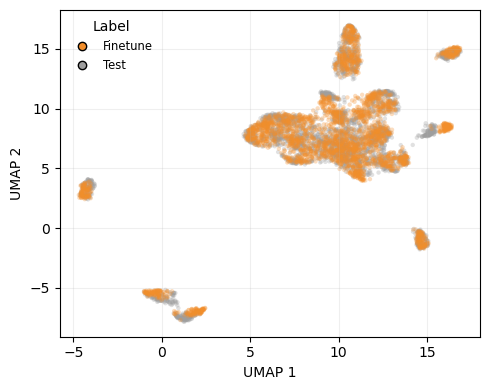

In [19]:
# X = np.vstack((z_train.cpu().detach().numpy(), z_finetune.cpu().detach().numpy()))
Y = np.array(['Test'] * z_train.shape[0] + ['Finetune'] * z_finetune.shape[0] ) 
# Y = np.hstack((y_test, y_finetune))
# Y = np.concatenate([y_test, y_finetune]) == np.concatenate([gmm_labels_train, gmm_labels_finetune])

# pca = PCA(n_components=20)  
# X_pca = pca.fit_transform(X)

# umap_reducer = umap.UMAP( n_components=2, n_neighbors=50,  min_dist=0.01, spread=1, metric='cosine', random_state=42, a = 0.9922, b = 1.112) 
# z_umap = umap_reducer.fit_transform(X_pca)

plot_UMAP( z_umap, Y, os.path.join('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model', 'Umap_Finetune_Test_z.png') , width = 5, height = 4)

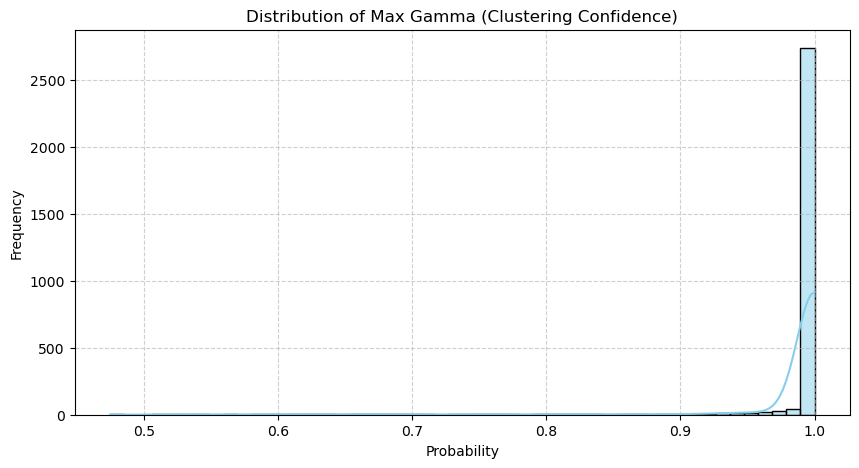

Mean Confidence: 0.9860
Samples with confidence > 0.9: 95.83%
Clustering Accuracy: 94.1000%
Clustering Accuracy: 75.3000%


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

max_gamma = np.max(gamma_finetune, axis=1)
# true_labels_wrong = y_test[wrong_idx] 
# gamma_wrong_samples = gamma_train[wrong_idx]
# max_gamma = gamma_wrong_samples[np.arange(len(true_labels_wrong)), true_labels_wrong]
# max_gamma = gamma_finetune[np.arange(len(y_finetune)),y_finetune]


plt.figure(figsize=(10, 5))
sns.histplot(max_gamma, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Max Gamma (Clustering Confidence)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Mean Confidence: {np.mean(max_gamma):.4f}")
print(f"Samples with confidence > 0.9: {np.sum(max_gamma > 0.9) / len(max_gamma) * 100:.2f}%")
acc = np.mean(y_finetune == gmm_labels_finetune)
print(f"Clustering Accuracy: {acc:.4%}")
acc = np.mean(y_test == gmm_labels_train)
print(f"Clustering Accuracy: {acc:.4%}")

In [ ]:
gamma_finetune[,y_finetune].shape

(3000,)

(1000,)


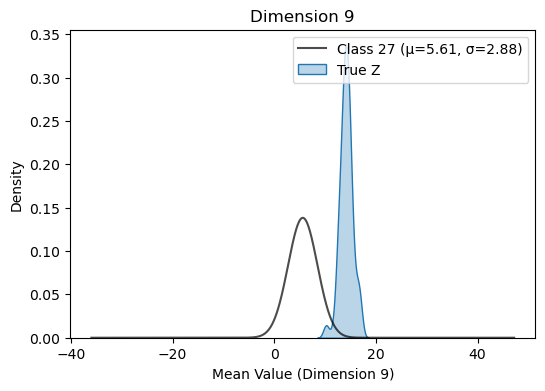

In [10]:
k = 5
dim = 9
cluster = 27
x_min = np.min(means[cluster,dim] - k * vars_[cluster,dim])
x_max = np.max(means[cluster,dim] + k * vars_[cluster,dim])

x = np.linspace(x_min, x_max, 1000)
print(x.shape)
plt.figure(figsize=(6, 4))

mu = means[cluster,dim]
var = std[cluster, dim]
y = norm.pdf(x, loc=mu, scale=var)

# 提取finetune的z
plot_data_z = z_finetune.detach().cpu().numpy()[y_finetune==cluster,dim]

plt.plot(x, y, label=f'Class {cluster} (μ={mu:.2f}, σ={var:.2f})', color='#000000', alpha=0.7)
sns.kdeplot( x=plot_data_z, fill=True, alpha=0.3, label='True Z')

plt.title(f'Dimension {dim}')
plt.xlabel(f'Mean Value (Dimension {dim})')
plt.ylabel('Density')
plt.legend()
plt.show()


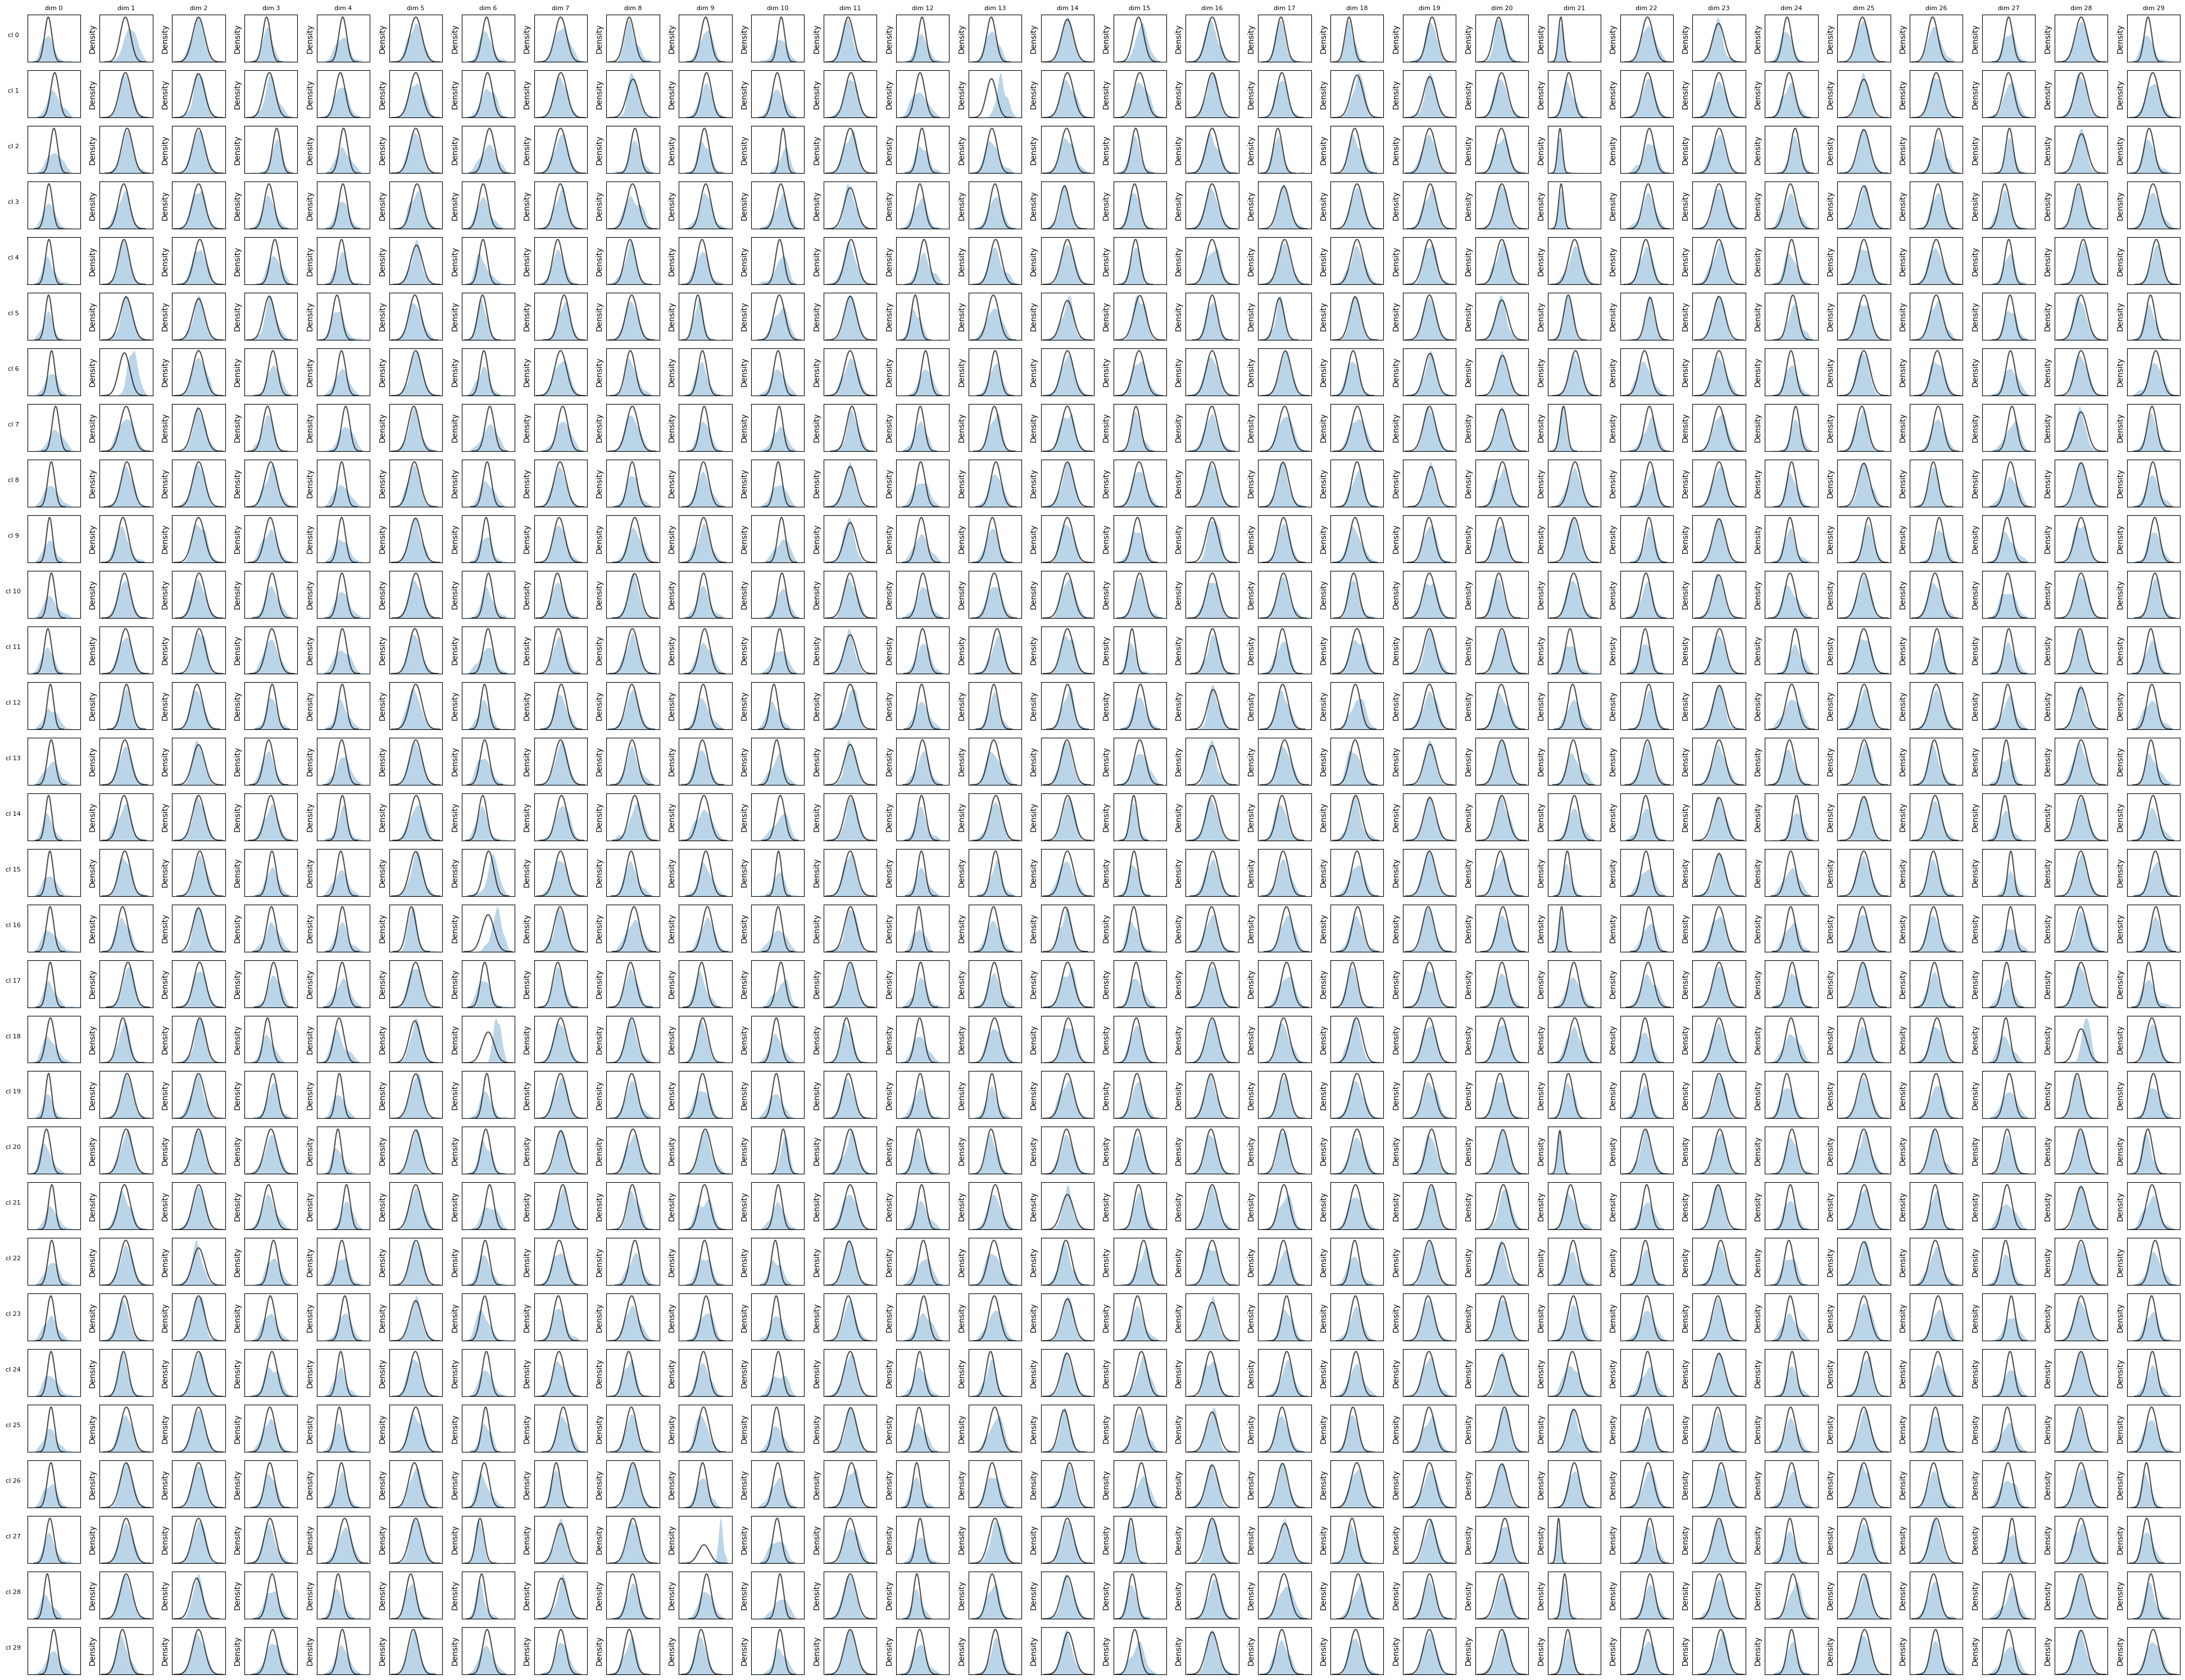

In [7]:
# 绘制所有样本的 
n_dims = 30      
k = 4
unique_labels = np.sort(np.unique(y_finetune))
n_clusters = len(unique_labels) 

fig, axes = plt.subplots(
    n_clusters,
    n_dims,
    figsize=(n_dims * 1.3, n_clusters * 1.0),
    sharex=False,
    sharey=False,
)

for row_idx, real_cluster_id in enumerate(unique_labels):
    for dim in range(n_dims):
        ax = axes[row_idx, dim]
        mu = means[row_idx, dim]
        var = std[row_idx, dim]

        x_min = mu - k * var
        x_max = mu + k * var
        x = np.linspace(x_min, x_max, 400)
        y = norm.pdf(x, loc=mu, scale=var)
        ax.plot(x, y, color="#000000", alpha=0.7)

        mask = (y_finetune == real_cluster_id)
        plot_data_z = z_finetune.detach().cpu().numpy()[mask, dim]
        if plot_data_z.size > 1:
            sns.kdeplot(
                x=plot_data_z,
                fill=True,
                alpha=0.3,
                color="tab:blue",
                ax=ax,
                linewidth=0,
            )

        ax.set_xticks([])
        ax.set_yticks([])
        if row_idx == 0:
            ax.set_title(f"dim {dim}", fontsize=8)
        if dim == 0:
            ax.set_ylabel(f"cl {real_cluster_id}", fontsize=8, rotation=0, labelpad=18)

plt.tight_layout()
plt.show()

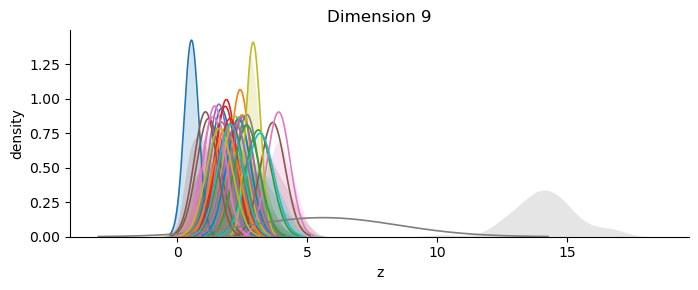

In [12]:
dim_to_plot = 9
k = 3
palette = dict(zip(unique_labels, sns.color_palette("tab10", n_clusters)))

fig, ax = plt.subplots(figsize=(7, 3))
for idx, real_cluster_id in enumerate(unique_labels):
    mu = means[idx, dim_to_plot]
    var = std[idx, dim_to_plot]

    x = np.linspace(mu - k * var, mu + k * var, 400)
    ax.plot(x, norm.pdf(x, loc=mu, scale=var),
            color=palette[real_cluster_id], lw=1.2, alpha=1,
            label=f"class {real_cluster_id} (pdf)")

    mask = (y_finetune == real_cluster_id)
    plot_data_z = z_finetune.detach().cpu().numpy()[mask, dim_to_plot]
    if plot_data_z.size > 1:
        sns.kdeplot(
            plot_data_z,
            ax=ax,
            color=palette[real_cluster_id],
            fill=True,
            alpha=0.2,
            linewidth=0,
            label=f"class {real_cluster_id} (data)",
        )

ax.set_title(f"Dimension {dim_to_plot}")
ax.set_xlabel("z")
ax.set_ylabel("density")
# ax.legend()
sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
import math
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

label_pairs = [(17,21), (15,16), (6,7), (4,9), (4,11), (2,22), (11,22), (13,12)]
samples_per_cluster = 200
num_clusters = 30
latent_dims = 30   # in case the tensor has more dims

# Precompute cluster colors (same as before)
pair_palette = sns.color_palette("Set2", len(label_pairs))
cluster_colors = {cid: "#c5c5c5" for cid in range(num_clusters)}
for idx, (a, b) in enumerate(label_pairs):
    color = pair_palette[idx]
    cluster_colors[a] = color
    cluster_colors[b] = color

sns.set(style="whitegrid")
rows = math.ceil(latent_dims / 3)
fig, axes = plt.subplots(rows, 3, figsize=(14, 3 * rows), constrained_layout=True)
axes = axes.flatten()

for dim_idx in range(latent_dims):
    ax = axes[dim_idx]
    cluster_samples = []
    for cid in range(num_clusters):
        mu = means[cid, dim_idx]
        std_c = std[cid, dim_idx]
        draws = torch.distributions.Normal(mu, std_c).sample((samples_per_cluster,)).numpy()
        cluster_samples.append(pd.DataFrame({"cluster": cid, "value": draws}))
    plot_df = pd.concat(cluster_samples, ignore_index=True)

    order = sorted(plot_df["cluster"].unique())
    palette = [cluster_colors[cid] for cid in order]

    sns.violinplot(
        x="cluster",
        y="value",
        data=plot_df,
        order=order,
        palette=palette,
        cut=0,
        linewidth=0.8,
        ax=ax,
    )
    ax.set_title(f"Latent dimension {dim_idx + 1}")
    ax.set_xlabel("")
    ax.set_ylabel("value")

# Hide any unused subplot if latent_dims is odd
for extra_ax in axes[latent_dims:]:
    extra_ax.set_visible(False)

plt.show()

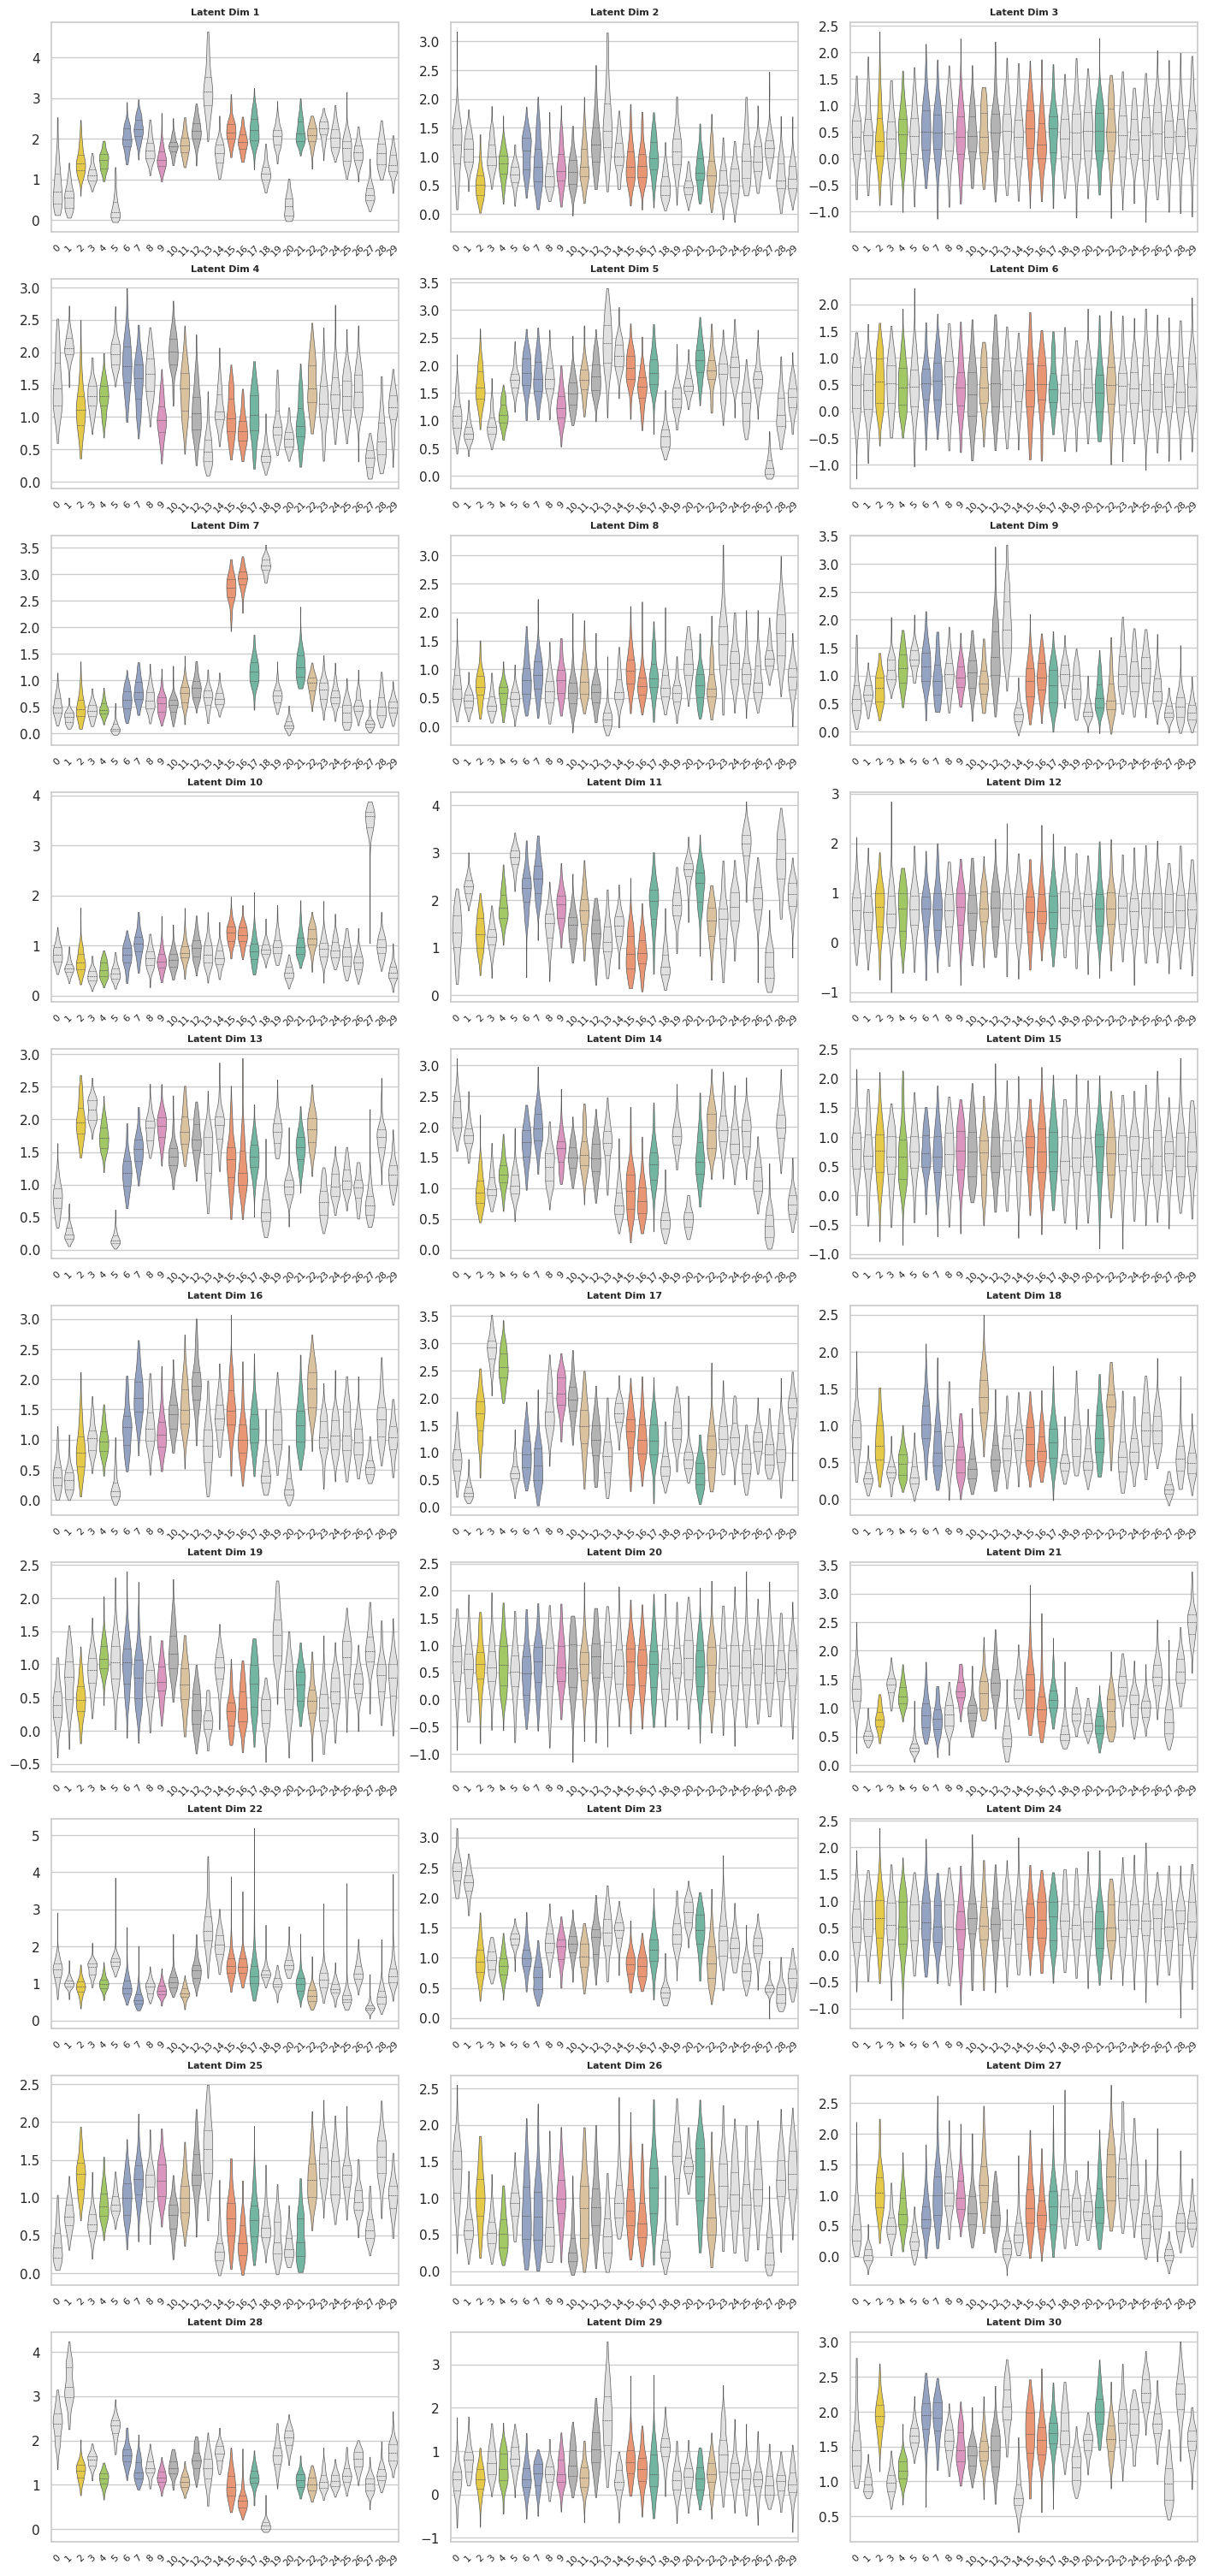

In [11]:
import math
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 假设 z_train 和 y_train 已经准备好 (可以是 Tensor 或 Numpy)
# z_train: [N, D], y_train: [N]
if isinstance(z_train, torch.Tensor):
    z_train_np = z_train.detach().cpu().numpy()
    y_train_np = y_test
else:
    z_train_np = z_train
    y_train_np = y_train

label_pairs = [(17,21), (15,16), (6,7), (4,9), (4,11), (2,22), (11,22), (10,12)]
num_clusters = 30
latent_dims = z_train_np.shape[1] # 自动获取实际维度

# --- 1. 预计算颜色 ---
pair_palette = sns.color_palette("Set2", len(label_pairs))
cluster_colors = {cid: "#e0e0e0" for cid in range(num_clusters)} # 默认灰色
for idx, (a, b) in enumerate(label_pairs):
    color = pair_palette[idx]
    if a < num_clusters: cluster_colors[a] = color
    if b < num_clusters: cluster_colors[b] = color

sns.set(style="whitegrid")
rows = math.ceil(latent_dims / 3)
fig, axes = plt.subplots(rows, 3, figsize=(14, 3 * rows), constrained_layout=True)
axes = axes.flatten()

# --- 2. 遍历每一个维度进行绘制 ---
for dim_idx in range(latent_dims):
    ax = axes[dim_idx]
    
    # 构造当前维度的 DataFrame
    # 包含所有样本在该维度的值及其所属 cluster
    plot_df = pd.DataFrame({
        "cluster": y_train_np,
        "value": z_train_np[:, dim_idx]
    })
    
    # 只绘制前 30 个类（或者你感兴趣的类）
    plot_df = plot_df[plot_df["cluster"] < num_clusters]
    
    order = sorted(plot_df["cluster"].unique())
    palette = [cluster_colors[cid] for cid in order]

    # 绘制小提琴图
    sns.violinplot(
        x="cluster",
        y="value",
        data=plot_df,
        order=order,
        palette=palette,
        cut=0,          # 不显示超出数据范围的延伸
        scale="width",  # 保持每个小提琴宽度一致，方便比较
        linewidth=0.5,
        inner="quartile", # 内部显示四分位数线，帮助观察分布集中度
        ax=ax,
    )
    
    ax.set_title(f"Latent Dim {dim_idx + 1}", fontsize=8, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")
    # 减少刻度密度避免拥挤
    ax.tick_params(axis='x', labelsize=8, rotation=45)

# 隐藏多余的子图
for extra_ax in axes[latent_dims:]:
    extra_ax.set_visible(False)

plt.show()

In [13]:
# 查看生成数据和原始数据的区别
import umap 
from sklearn.decomposition import PCA
import numpy as np
import os
# X_Generate = np.load('/mnt/sda/gene/zhangym/VADER/Augmentation/Gene_spectra/Generated_Spectra/NC_All_Add_Class/NC30_X_gene_cVADER_1216_cVADER_M2_Only_Finetune.npy')
# y_Generate = np.load('/mnt/sda/gene/zhangym/VADER/Augmentation/Gene_spectra/Generated_Spectra/NC_All_Add_Class/NC30_Y_gene_cVADER_1216_cVADER_M2_Only_Finetune.npy').astype(int)

# # 随机取100个，以避免权重过大
# rng = np.random.default_rng(42)  
# samples_per_class = 100
# keep_idx = []
# for lbl in np.unique(y_Generate):
#     cls_idx = np.where(y_Generate == lbl)[0]
#     keep_idx.append(rng.choice(cls_idx, samples_per_class, replace=False))

# keep_idx = np.concatenate(keep_idx)
# X_Generate = X_Generate[keep_idx]
# y_Generate = y_Generate[keep_idx]


# X = np.vstack((X_finetune, X_Generate))
Y = np.array(['Raw Finetune'] * X_finetune.shape[0] + ['VaDE Generated'] * X_Generate.shape[0] ) 
# Y = np.hstack((y_finetune, y_Generate))

# pca = PCA(n_components=20)  
# X_pca = pca.fit_transform(X)

# umap_reducer = umap.UMAP( n_components=2, n_neighbors=50,  min_dist=0.01, spread=1, metric='cosine', random_state=42, a = 0.9922, b = 1.112) 
# z_umap = umap_reducer.fit_transform(X_pca)

plot_UMAP( z_umap, Y, os.path.join('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model', 'Umap_Finetune_Test.png') , width = 5, height = 4)

NameError: name 'X_Generate' is not defined

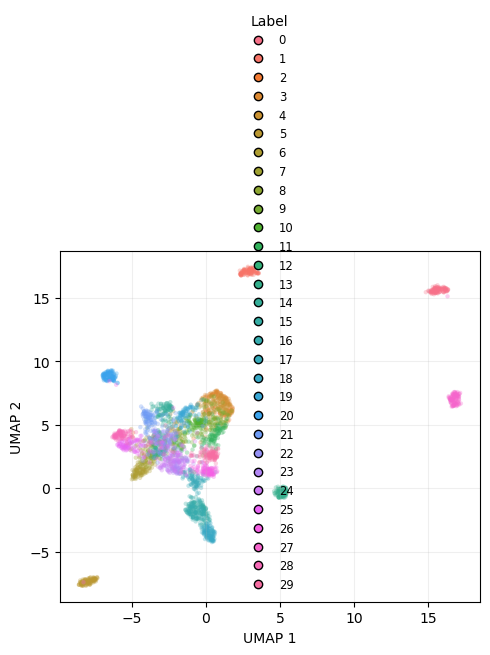

In [22]:
# 查看Finetune的隐含层
# pca = PCA(n_components=20)  
# X_pca = pca.fit_transform(z_finetune.detach().cpu().numpy())

# umap_reducer = umap.UMAP( n_components=2, n_neighbors=50,  min_dist=0.01, spread=1, metric='cosine', random_state=42, a = 0.9922, b = 1.112) 
# z_umap = umap_reducer.fit_transform(X_pca)

plot_UMAP( z_umap, y_finetune, os.path.join('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model', 'Umap_Finetune_Test.png') , width = 5, height = 5.5)

(1000,)


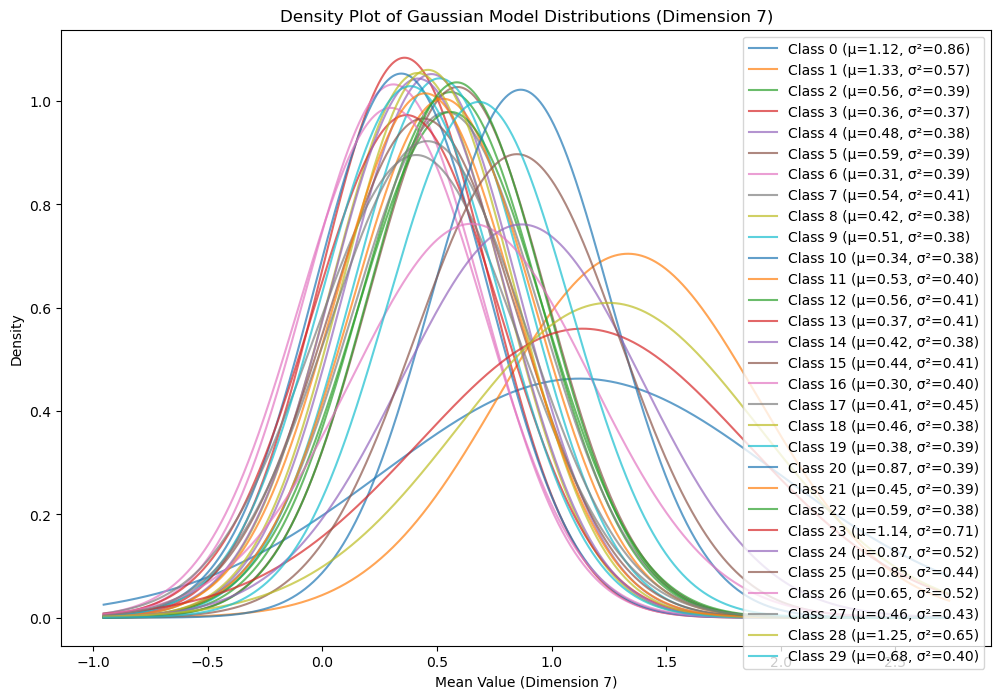

In [36]:
k = 3
dim = 7
cluster = 7
x_min = np.min(means[:,dim] - k * vars_[dim])
x_max = np.max(means[:,dim] + k * vars_[dim])

x = np.linspace(x_min, x_max, 1000)
print(x.shape)
plt.figure(figsize=(12, 8))

for i, (mu, var) in enumerate(zip(means[:,dim], vars_[:,dim])):
    y = norm.pdf(x, loc=mu, scale=var)
    plt.plot(x, y, label=f'Class {i} (μ={mu:.2f}, σ²={var:.2f})', color=plt.cm.tab10(i % 10), alpha=0.7)


plt.title(f'Density Plot of Gaussian Model Distributions (Dimension {dim})')
plt.xlabel(f'Mean Value (Dimension {dim})')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# Draw mean Spec


(3000, 1000)

In [17]:
threshold = 0.95

print(gaussian_means.shape)
z_sample=np.random.multivariate_normal(gaussian_means[1,:],np.diag(np.exp(gaussian_vars[1,:])),(1,))

(10, 20)


In [18]:
z_prob = F.softmax(model.gaussian.gaussian_log_prob(torch.tensor(z_sample).to(device)), dim=1)

if z_prob.max() > threshold:
    new_X = np.matmul(z_sample, S.cpu().detach().numpy())

In [22]:
real_cluster_id

tensor(8, device='cuda:1')